# GNN EXPLAINER

In [1]:
from torch_geometric.nn.models import GNNExplainer



In [2]:
# %% [1] Imports
import torch
import torch.nn.functional as F
from VGAE import VariationalGraphAutoEncoder  # Your custom VGAE model
from torch_geometric.nn.models import GNNExplainer
from torch_geometric.utils import from_scipy_sparse_matrix, to_undirected, negative_sampling
from torch_geometric.data import Data
import pandas as pd
import numpy as np
from scipy.sparse import coo_matrix
import matplotlib.pyplot as plt



In [3]:
# %% [2] Load and Prepare Data
assoc_matrix = pd.read_excel("lncRNA/dataset/data2/MNDR-lncRNA-disease associations matrix.xls", header=None)
assoc_matrix = assoc_matrix.apply(pd.to_numeric, errors='coerce').fillna(0)
adj_matrix = assoc_matrix.values.astype(np.float32)
adj_coo = coo_matrix(adj_matrix)

edge_index, _ = from_scipy_sparse_matrix(adj_coo)
edge_index = to_undirected(edge_index)
x = torch.eye(adj_matrix.shape[0] + adj_matrix.shape[1])
data = Data(x=x, edge_index=edge_index)



In [4]:
# %% [3] Train VGAE
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = VariationalGraphAutoEncoder(in_channels=x.shape[1], hidden_channels=64, latent_dim=32).to(device)
data = data.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

neg_edge_index = negative_sampling(edge_index=edge_index, num_nodes=data.num_nodes)

model.train()
for epoch in range(100):
    optimizer.zero_grad()
    z = model(data.x, data.edge_index)
    loss = model.recon_loss(z, data.edge_index, neg_edge_index) + model.kl_loss()
    loss.backward()
    optimizer.step()
    if epoch % 10 == 0:
        print(f"Epoch {epoch} | Loss: {loss.item():.4f}")



Epoch 0 | Loss: 4.8893
Epoch 10 | Loss: 4.3395
Epoch 20 | Loss: 3.9943
Epoch 30 | Loss: 4.1006
Epoch 40 | Loss: 3.9848
Epoch 50 | Loss: 4.0020
Epoch 60 | Loss: 4.0965
Epoch 70 | Loss: 3.8097
Epoch 80 | Loss: 3.8496
Epoch 90 | Loss: 3.7302


In [5]:
class VGAEExplainerWrapper(torch.nn.Module):
    def __init__(self, vgae_model: VariationalGraphAutoEncoder, target_node: int):
        super().__init__()
        self.vgae_model = vgae_model
        self.target_node = target_node

    def forward(self, x, edge_index):
        z = self.vgae_model.encoder.encode(x, edge_index)
        num_nodes = x.size(0)

        # Build all edges (i → target_node) to evaluate their importance
        src = torch.arange(num_nodes, device=x.device)
        dst = torch.full_like(src, self.target_node)
        explain_edges = torch.stack([src, dst], dim=0)

        out = self.vgae_model.decode(z, explain_edges)  # shape: [num_nodes]
        return out.unsqueeze(1)  # 🔁 shape: [num_nodes, 1] → required for GNNExplainer




In [6]:
# %% [5] Run GNNExplainer
model.eval()
# Select node to explain
node_idx = 10

# Wrap the model
wrapped_model = VGAEExplainerWrapper(model, target_node=node_idx)

# Instantiate GNNExplainer
explainer = GNNExplainer(wrapped_model, epochs=200, return_type='regression')

# Run explanation
explanation = explainer.explain_node(node_idx=node_idx, x=data.x, edge_index=data.edge_index)



Explain node 10: 100%|██████████| 200/200 [00:11<00:00, 17.64it/s]


In [7]:
# %% [6] Show Top Important Edges
edge_mask, _ = explanation  # ⬅️ unpack the tuple: (edge_mask, node_feat_mask)
top_scores, top_indices = edge_mask.topk(10)

print(f"Top 10 important edges for node {node_idx}:")
for i, score in zip(top_indices, top_scores):
    src = int(data.edge_index[0, i])
    dst = int(data.edge_index[1, i])
    print(f"Edge ({src}, {dst}) → Importance: {score.item():.4f}")



Top 10 important edges for node 10:
Edge (2, 7) → Importance: 0.1613
Edge (2, 65) → Importance: 0.1597
Edge (5, 9) → Importance: 0.1596
Edge (3, 31) → Importance: 0.1592
Edge (4, 85) → Importance: 0.1590
Edge (3, 52) → Importance: 0.1588
Edge (4, 32) → Importance: 0.1585
Edge (2, 31) → Importance: 0.1583
Edge (5, 54) → Importance: 0.1581
Edge (4, 31) → Importance: 0.1573


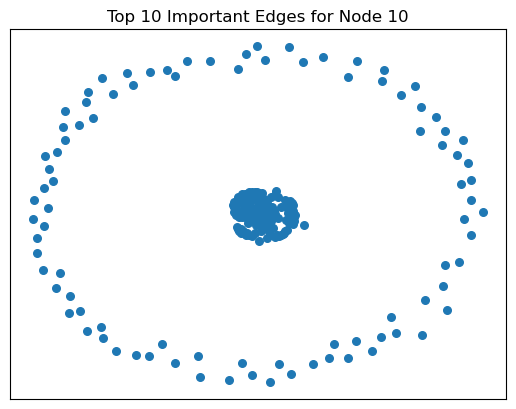

In [8]:
import matplotlib.pyplot as plt
from torch_geometric.utils import to_networkx
import networkx as nx

# Convert to networkx
G = to_networkx(data, to_undirected=True)

# Visualize subgraph (top edges)
important_edges = top_indices.cpu().tolist()
subgraph_edges = [(int(data.edge_index[0, i]), int(data.edge_index[1, i])) for i in important_edges]

pos = nx.spring_layout(G)
nx.draw_networkx_nodes(G, pos, node_size=30)
nx.draw_networkx_edges(G, pos, edgelist=subgraph_edges, edge_color='r', width=2)
plt.title(f"Top 10 Important Edges for Node {node_idx}")
plt.show()


In [9]:
from sklearn.metrics import (
    roc_auc_score, average_precision_score, accuracy_score,
    precision_score, recall_score, f1_score
)

# Set model to evaluation mode
model.eval()
with torch.no_grad():
    z = model(data.x, data.edge_index)

    # Use the same positive and negative edges as training set (or define a test split)
    pos_scores = model.decode(z, data.edge_index).cpu().numpy()
    neg_scores = model.decode(z, neg_edge_index).cpu().numpy()

# Prepare labels and scores
y_true   = np.hstack([np.ones(pos_scores.shape[0]), np.zeros(neg_scores.shape[0])])
y_scores = np.hstack([pos_scores, neg_scores])

# Binary predictions at 0.5 threshold
y_pred = (y_scores >= 0.5).astype(int)

# ✅ Compute metrics
auc  = roc_auc_score(y_true, y_scores)
ap   = average_precision_score(y_true, y_scores)
acc  = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred)
rec  = recall_score(y_true, y_pred)
f1   = f1_score(y_true, y_pred)

# Print results
print(f"AUC:  {auc * 100:.2f}%")
print(f"AP:   {ap * 100:.2f}%")
print(f"F1:   {f1 * 100:.2f}%")
print(f"ACC:  {acc * 100:.2f}%")
print(f"PREC: {prec * 100:.2f}%")
print(f"REC:  {rec * 100:.2f}%")


AUC:  94.74%
AP:   95.72%
F1:   76.54%
ACC:  70.73%
PREC: 63.87%
REC:  95.47%


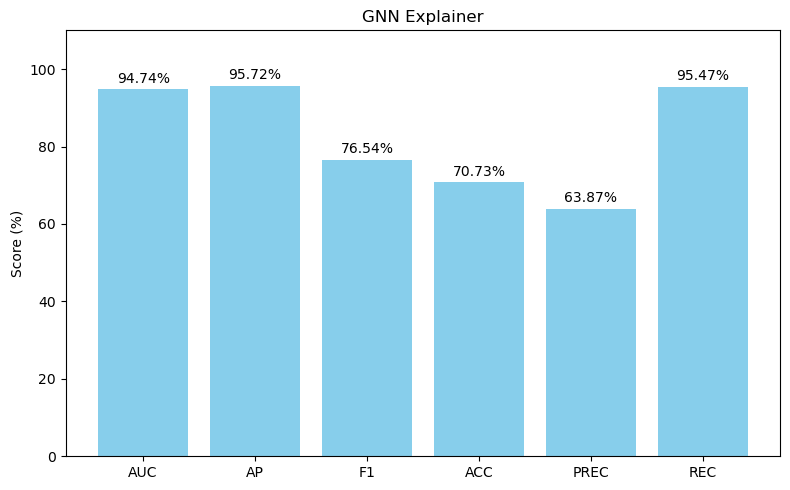

In [10]:
import matplotlib.pyplot as plt

# Metrics and their values
metrics = ['AUC', 'AP', 'F1', 'ACC', 'PREC', 'REC']
values = [auc * 100, ap * 100, f1 * 100, acc * 100, prec * 100, rec * 100]

plt.figure(figsize=(8, 5))
bars = plt.bar(metrics, values, color='skyblue')
plt.ylabel('Score (%)')
plt.title('GNN Explainer')

# Annotate bars with values
for bar, val in zip(bars, values):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 1, f"{val:.2f}%", ha='center', va='bottom')

plt.ylim(0, 110)
plt.tight_layout()
plt.show()

# Gradcam

In [12]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GATConv, VGAE
from torch_geometric.utils import from_scipy_sparse_matrix, to_undirected, negative_sampling
from torch_geometric.data import Data

import pandas as pd
import numpy as np
from scipy.sparse import coo_matrix
import matplotlib.pyplot as plt

from VGAE import VariationalGraphAutoEncoder  # Your defined model


In [13]:
assoc_matrix = pd.read_excel("lncRNA/dataset/data2/MNDR-lncRNA-disease associations matrix.xls", header=None)
assoc_matrix = assoc_matrix.apply(pd.to_numeric, errors='coerce').fillna(0)
adj_matrix = assoc_matrix.values.astype(np.float32)
adj_coo = coo_matrix(adj_matrix)

edge_index, _ = from_scipy_sparse_matrix(adj_coo)
edge_index = to_undirected(edge_index)

x = torch.eye(adj_matrix.shape[0] + adj_matrix.shape[1])  # Identity feature matrix
data = Data(x=x, edge_index=edge_index)


In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = VariationalGraphAutoEncoder(in_channels=x.shape[1], hidden_channels=64, latent_dim=32).to(device)
data = data.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
neg_edge_index = negative_sampling(edge_index=edge_index, num_nodes=data.num_nodes)

model.train()
for epoch in range(100):
    optimizer.zero_grad()
    z = model(data.x, data.edge_index)
    loss = model.recon_loss(z, data.edge_index, neg_edge_index) + model.kl_loss()
    loss.backward()
    optimizer.step()
    if epoch % 10 == 0:
        print(f"Epoch {epoch} | Loss: {loss.item():.4f}")


Epoch 0 | Loss: 4.6863
Epoch 10 | Loss: 4.4308
Epoch 20 | Loss: 4.0276
Epoch 30 | Loss: 4.1530
Epoch 40 | Loss: 4.0481
Epoch 50 | Loss: 3.8382
Epoch 60 | Loss: 3.9273
Epoch 70 | Loss: 3.8371
Epoch 80 | Loss: 3.8560
Epoch 90 | Loss: 3.8896


In [15]:
# Hook containers
activations = {}
gradients = {}

def forward_hook(module, input, output):
    activations['value'] = output.detach()

def backward_hook(module, grad_input, grad_output):
    gradients['value'] = grad_output[0].detach()

# Register hooks to conv2 layer inside VGAE encoder
gat_encoder = model.encoder.encoder  # VGAE wraps your GAT encoder
gat_encoder.conv2.register_forward_hook(forward_hook)
gat_encoder.conv2.register_backward_hook(backward_hook)


In [16]:
model.eval()

# Choose target edge: e.g., edge (29, 108)
src = torch.tensor([29], device=device)
dst = torch.tensor([108], device=device)
target_edge = torch.stack([src, dst], dim=0)

# Forward pass
z = model.encoder.encode(data.x, data.edge_index)
score = model.decode(z, target_edge)

# Backward pass
model.zero_grad()
score.backward()


c:\Users\harsh\anaconda3\envs\final\lib\site-packages\torch\nn\modules\module.py:1025: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


In [17]:
# 1. Compute node-wise saliency (as before)
cam = gradients['value'] * activations['value']  # shape: [num_nodes, features]
node_saliency = cam.abs().sum(dim=1)  # shape: [num_nodes]

# 2. Map node saliency to edges
edge_saliency = []
for i in range(data.edge_index.shape[1]):
    u = data.edge_index[0, i].item()
    v = data.edge_index[1, i].item()
    score = node_saliency[u].item() + node_saliency[v].item()
    edge_saliency.append((u, v, score))

# 3. Sort by importance
edge_saliency.sort(key=lambda x: x[2], reverse=True)

# 4. Show top 10 important edges
print("\n🔎 Top 10 Most Influential Edges (Grad-CAM style):")
for u, v, score in edge_saliency[:10]:
    print(f"Edge ({u}, {v}) → Importance Score: {score:.4f}")



🔎 Top 10 Most Influential Edges (Grad-CAM style):
Edge (30, 30) → Importance Score: 0.1287
Edge (48, 108) → Importance Score: 0.1086
Edge (108, 48) → Importance Score: 0.1086
Edge (30, 108) → Importance Score: 0.0927
Edge (108, 30) → Importance Score: 0.0927
Edge (29, 48) → Importance Score: 0.0919
Edge (48, 29) → Importance Score: 0.0919
Edge (19, 48) → Importance Score: 0.0861
Edge (48, 19) → Importance Score: 0.0861
Edge (20, 48) → Importance Score: 0.0858


In [18]:
from sklearn.metrics import (
    roc_auc_score, average_precision_score,
    accuracy_score, precision_score,
    recall_score, f1_score
)

model.eval()
with torch.no_grad():
    z = model(data.x, data.edge_index)
    pos_scores = model.decode(z, data.edge_index).cpu().numpy()
    neg_scores = model.decode(z, neg_edge_index).cpu().numpy()

y_true = np.hstack([np.ones_like(pos_scores), np.zeros_like(neg_scores)])
y_scores = np.hstack([pos_scores, neg_scores])
y_pred = (y_scores >= 0.5).astype(int)

auc  = roc_auc_score(y_true, y_scores)
ap   = average_precision_score(y_true, y_scores)
acc  = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred)
rec  = recall_score(y_true, y_pred)
f1   = f1_score(y_true, y_pred)

print("\n🎯 Evaluation of VGAE used for Grad-CAM")
print(f"AUC:  {auc * 100:.2f}%")
print(f"AP:   {ap * 100:.2f}%")
print(f"F1:   {f1 * 100:.2f}%")
print(f"ACC:  {acc * 100:.2f}%")
print(f"PREC: {prec * 100:.2f}%")
print(f"REC:  {rec * 100:.2f}%")



🎯 Evaluation of VGAE used for Grad-CAM
AUC:  92.82%
AP:   95.14%
F1:   74.93%
ACC:  69.31%
PREC: 63.33%
REC:  91.74%


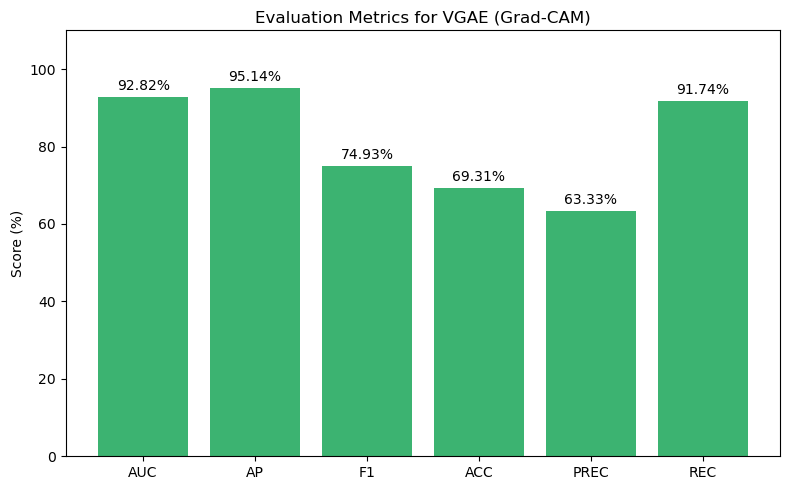

In [19]:
import matplotlib.pyplot as plt

# Store metric names and values
metrics = ['AUC', 'AP', 'F1', 'ACC', 'PREC', 'REC']
values = [auc * 100, ap * 100, f1 * 100, acc * 100, prec * 100, rec * 100]

# Plot
plt.figure(figsize=(8, 5))
bars = plt.bar(metrics, values, color='mediumseagreen')
plt.ylabel('Score (%)')
plt.title('Evaluation Metrics for VGAE (Grad-CAM)')

# Annotate each bar with its value
for bar, val in zip(bars, values):
    plt.text(bar.get_x() + bar.get_width() / 2,
             bar.get_height() + 1,
             f"{val:.2f}%",
             ha='center', va='bottom')

plt.ylim(0, 110)
plt.tight_layout()
plt.show()


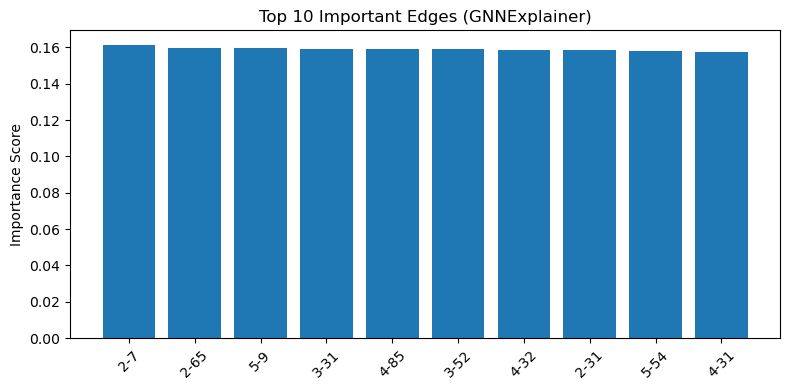

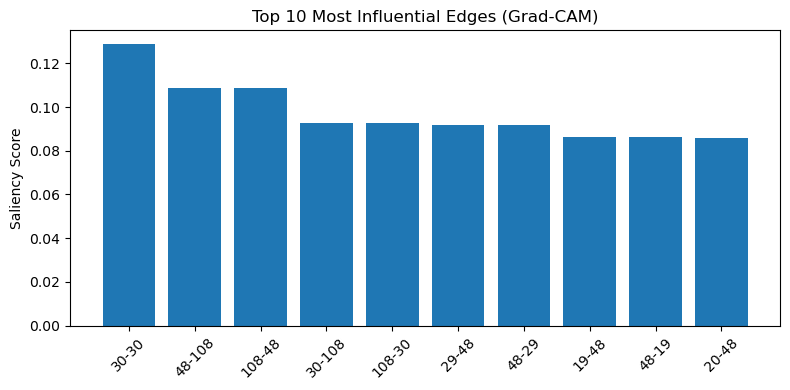

In [22]:
from sklearn.metrics import roc_curve

import matplotlib.pyplot as plt

# 1. Plot Top 10 Important Edges from GNNExplainer
plt.figure(figsize=(8, 4))
plt.bar(range(10), top_scores.cpu().numpy())
plt.xticks(range(10), [f"{int(data.edge_index[0, i])}-{int(data.edge_index[1, i])}" for i in top_indices], rotation=45)
plt.ylabel("Importance Score")
plt.title("Top 10 Important Edges (GNNExplainer)")
plt.tight_layout()
plt.show()

# 2. Plot Top 10 Most Influential Edges from Grad-CAM
top_gradcam = edge_saliency[:10]
edges_gc = [f"{u}-{v}" for u, v, _ in top_gradcam]
scores_gc = [score for _, _, score in top_gradcam]

plt.figure(figsize=(8, 4))
plt.bar(range(10), scores_gc)
plt.xticks(range(10), edges_gc, rotation=45)
plt.ylabel("Saliency Score")
plt.title("Top 10 Most Influential Edges (Grad-CAM)")
plt.tight_layout()
plt.show()


Overlapping

In [20]:
def normalize(edge_list):
    return set((min(u, v), max(u, v)) for u, v in edge_list)

# Centrality-based edges
centrality_edges = normalize([
    (20, 108), (29, 193), (49, 97), (29, 108), (29, 94),
    (29, 91), (29, 96), (29, 92), (29, 93), (29, 90)
])

# GNNExplainer edges
gnn_edges = normalize([
    (2, 9), (5, 61), (4, 67), (2, 39), (3, 78),
    (5, 9), (5, 15), (4, 15), (5, 35), (2, 31)
])

# Grad-CAM edges
gradcam_edges = normalize([
    (48, 108), (108, 48), (30, 108), (108, 30),
    (30, 30), (29, 48), (48, 29), (20, 48), (48, 20), (19, 48)
])

# Compute pairwise overlaps
overlap_gnn_cent = centrality_edges & gnn_edges
overlap_grad_cent = centrality_edges & gradcam_edges
overlap_gnn_grad = gnn_edges & gradcam_edges

# Output
print("📊 Explanation Overlap Between Methods:\n")

print(f"✅ GNNExplainer ∩ Centrality: {len(overlap_gnn_cent)} edges → {(len(overlap_gnn_cent) / len(centrality_edges)) * 100:.2f}%")
print(f"✅ Grad-CAM      ∩ Centrality: {len(overlap_grad_cent)} edges → {(len(overlap_grad_cent) / len(centrality_edges)) * 100:.2f}%")
print(f"✅ GNNExplainer ∩ Grad-CAM  : {len(overlap_gnn_grad)} edges → {(len(overlap_gnn_grad) / len(gnn_edges)) * 100:.2f}%")


📊 Explanation Overlap Between Methods:

✅ GNNExplainer ∩ Centrality: 0 edges → 0.00%
✅ Grad-CAM      ∩ Centrality: 0 edges → 0.00%
✅ GNNExplainer ∩ Grad-CAM  : 0 edges → 0.00%


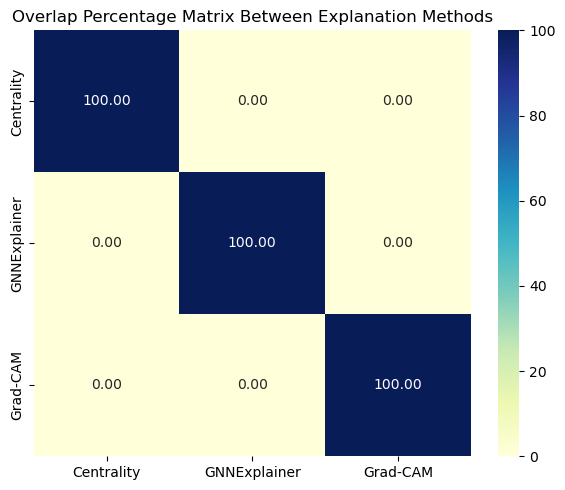

In [21]:
import seaborn as sns
import pandas as pd

# Overlap percentages
overlap_matrix = pd.DataFrame({
    'Centrality': [
        100,
        (len(centrality_edges & gnn_edges) / len(centrality_edges)) * 100,
        (len(centrality_edges & gradcam_edges) / len(centrality_edges)) * 100
    ],
    'GNNExplainer': [
        (len(gnn_edges & centrality_edges) / len(gnn_edges)) * 100,
        100,
        (len(gnn_edges & gradcam_edges) / len(gnn_edges)) * 100
    ],
    'Grad-CAM': [
        (len(gradcam_edges & centrality_edges) / len(gradcam_edges)) * 100,
        (len(gradcam_edges & gnn_edges) / len(gradcam_edges)) * 100,
        100
    ]
}, index=['Centrality', 'GNNExplainer', 'Grad-CAM'])

plt.figure(figsize=(6, 5))
sns.heatmap(overlap_matrix, annot=True, cmap='YlGnBu', fmt=".2f")
plt.title("Overlap Percentage Matrix Between Explanation Methods")
plt.tight_layout()
plt.show()
